**All (or most) includes**

In [2]:
#  |  This is setup, actual work is down
#  |
# \ /
#  V

from sklearn.metrics import classification_report
from keras.models import Sequential, load_model, clone_model
from keras.layers import Dense, Activation, Convolution2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from keras import models, layers, optimizers, utils
from keras.callbacks import EarlyStopping, Callback
import PIL, PIL.ImageOps, PIL.ImageEnhance, PIL.ImageDraw, PIL.Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import time
import random
import sys
from IPython.display import clear_output

Using TensorFlow backend.


**=== Child Model and Model Functions ===**

In [0]:
#  |  This is setup, actual work is down
#  |
# \ /
#  V

def create_model(X_train, n_classes, num_classes = 10, use_dropout = False):
    #https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py
    model = Sequential()
    model.add(Convolution2D(32, (3, 3), padding='same',
                input_shape=X_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Convolution2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    if use_dropout:
      model.add(Dropout(0.25))
    
    model.add(Convolution2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Convolution2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    if use_dropout:
      model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    if use_dropout:
      model.add(Dropout(0.5))
    
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    opt = optimizers.rmsprop(lr=0.0001, decay=1e-6)
    #opt = optimizers.Adadelta(lr=0.05, rho=0.95, epsilon=None, decay=0.0)
    model.compile(opt, 'categorical_crossentropy', ['accuracy'])
    return model

def model_cond_accuracy(model, X, y):
    y_prob = model.predict(X)
    y_classes = y_prob.argmax(axis=-1).tolist()
    y_test = y.argmax(axis=-1).tolist()
    total = [0] * 10
    counts = [0] * 10
    for i in range(len(y_classes)):
      if y_classes[i] == y_test[i]:
        total[y_test[i]] += 1
      counts[y_test[i]] += 1
    acc = [0.0] * 10
    for i in range(10):
      if 0 != counts[i]:
        acc[i] = total[i] / counts[i]
    return acc

# Like to see progress, but don't want hundreds of
# status bars for each training session!
class CallBackClearLine(Callback):
    def on_epoch_begin(self, epoch, logs={}):
      clear_output()
      print('Epoch ' + str(epoch) + ': ')
      return
 
    def on_epoch_end(self, epoch, logs={}):
      return

# Standardize training
# Using the EarlyStopping callback to enforce consistent stop times 
def model_fit(model, gen, val_data, nbatches, epochs):
    stop = EarlyStopping(patience=1000, restore_best_weights=True)
    history = model.fit_generator(
        gen, 
        nbatches, 
        epochs, 
        verbose=0, 
        use_multiprocessing=True, 
        validation_data =  val_data, 
        callbacks=[stop])
    return history

# Returns accurac of the model
def model_evaluate(model, X, y):
  return model.evaluate(X, y, verbose=0)[1]

**=== Transforms ===**

In [0]:
# === Data Transforms and Policy Classes ===

#  |  This is setup, actual work is down
#  |
# \ /
#  V

# Code below adapted from augmentation_transforms.py
# Modified to support transforms at the image class level
# Original copywright below:

# Copyright 2018 The TensorFlow Authors All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================



IMAGE_SIZE = 32
MEANS = [0.49139968, 0.48215841, 0.44653091]
STDS = [0.24703223, 0.24348513, 0.26158784]
PARAMETER_MAX = 10  # What is the max 'level' a transform could be predicted

def pil_wrap(img):
  """Convert the `img` numpy tensor to a PIL Image."""
  return PIL.Image.fromarray(
      np.uint8((img * STDS + MEANS) * 255.0)).convert('RGBA')


def pil_unwrap(pil_img):
  """Converts the PIL img to a numpy array."""
  pic_array = (np.array(pil_img.getdata()).reshape((32, 32, 4)) / 255.0)
  i1, i2 = np.where(pic_array[:, :, 3] == 0)
  pic_array = (pic_array[:, :, :3] - MEANS) / STDS
  pic_array[i1, i2] = [0, 0, 0]
  return pic_array

class Operation:
    def __init__(self, t, p = 0.5):

        self.prob = p
        self.magnitudes = t[1]
        self.transformation = t[0]
        
    def __call__(self, X, Y):
        _X = []
        #self.magnitudes = [random.randint(0,10)] * 10
        for x,y in zip(X,Y):
            if np.random.rand() < self.prob:
                x = pil_wrap(x)
                yindex = np.argmax(y)
                x = self.transformation[yindex](x, self.magnitudes[yindex])
                x = pil_unwrap(x)
            _X.append(np.array(x))
        return np.array(_X)
    

class SubPolicy:
    def __init__(self, *operations):
        self.operations = operations

    def __call__(self, X, Y):
        for op in self.operations:
            X = op(X, Y)
        return X


def autoaugment(transforms, X, y, batch_size):
    while True:
        ix = np.arange(len(X))
        np.random.shuffle(ix)
        for i in range(len(X) // batch_size):
            _ix = ix[i*batch_size:(i+1)*batch_size]
            _X = X[_ix]
            _y = y[_ix]
            if 0 != len(transforms):
              transform = np.random.choice(transforms)
              _X = transform(_X, _y)
            yield _X, _y

# modified from https://github.com/rpmcruz/autoaugment/blob/master/transformations.py
def create_cutout_mask(img_height, img_width, num_channels, size):
  """Creates a zero mask used for cutout of shape `img_height` x `img_width`.

  Args:
    img_height: Height of image cutout mask will be applied to.
    img_width: Width of image cutout mask will be applied to.
    num_channels: Number of channels in the image.
    size: Size of the zeros mask.

  Returns:
    A mask of shape `img_height` x `img_width` with all ones except for a
    square of zeros of shape `size` x `size`. This mask is meant to be
    elementwise multiplied with the original image. Additionally returns
    the `upper_coord` and `lower_coord` which specify where the cutout mask
    will be applied.
  """
  assert img_height == img_width

  # Sample center where cutout mask will be applied
  height_loc = np.random.randint(low=0, high=img_height)
  width_loc = np.random.randint(low=0, high=img_width)

  # Determine upper right and lower left corners of patch
  upper_coord = (max(0, height_loc - size // 2), max(0, width_loc - size // 2))
  lower_coord = (min(img_height, height_loc + size // 2),
                 min(img_width, width_loc + size // 2))
  mask_height = lower_coord[0] - upper_coord[0]
  mask_width = lower_coord[1] - upper_coord[1]
  assert mask_height > 0
  assert mask_width > 0

  mask = np.ones((img_height, img_width, num_channels))
  zeros = np.zeros((mask_height, mask_width, num_channels))
  mask[upper_coord[0]:lower_coord[0], upper_coord[1]:lower_coord[1], :] = (
      zeros)
  return mask, upper_coord, lower_coord

def cutout_numpy(img, size=16):
  """Apply cutout with mask of shape `size` x `size` to `img`.

  The cutout operation is from the paper https://arxiv.org/abs/1708.04552.
  This operation applies a `size`x`size` mask of zeros to a random location
  within `img`.

  Args:
    img: Numpy image that cutout will be applied to.
    size: Height/width of the cutout mask that will be

  Returns:
    A numpy tensor that is the result of applying the cutout mask to `img`.
  """
  img_height, img_width, num_channels = (img.shape[0], img.shape[1],
                                         img.shape[2])
  assert len(img.shape) == 3
  mask, _, _ = create_cutout_mask(img_height, img_width, num_channels, size)
  return img * mask

def float_parameter(level, maxval):
  """Helper function to scale `val` between 0 and maxval .

  Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled
      to level/PARAMETER_MAX.

  Returns:
    A float that results from scaling `maxval` according to `level`.
  """
  return float(level) * maxval / PARAMETER_MAX


def int_parameter(level, maxval):
  """Helper function to scale `val` between 0 and maxval .

  Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled
      to level/PARAMETER_MAX.

  Returns:
    An int that results from scaling `maxval` according to `level`.
  """
  return int(level * maxval / PARAMETER_MAX)

def _cutout_pil_impl(pil_img, level):
  """Apply cutout to pil_img at the specified level."""
  size = int_parameter(level, 20)
  if size <= 0:
    return pil_img
  img_height, img_width, num_channels = (32, 32, 3)
  _, upper_coord, lower_coord = (
      create_cutout_mask(img_height, img_width, num_channels, size))
  pixels = pil_img.load()  # create the pixel map
  for i in range(upper_coord[0], lower_coord[0]):  # for every col:
    for j in range(upper_coord[1], lower_coord[1]):  # For every row
      pixels[i, j] = (125, 122, 113, 0)  # set the colour accordingly
  return pil_img

def _enhancer_impl(enhancer):
  """Sets level to be between 0.1 and 1.8 for ImageEnhance transforms of PIL."""
  def impl(pil_img, level):
    v = float_parameter(level, 1.8) + .1  # going to 0 just destroys it
    return enhancer(pil_img).enhance(v)
  return impl

# =============================================================================

def ShearX(img, v):  # [-0.3, 0.3]
    v = float_parameter(v, 0.3)
    if random.random() > 0.5:
      v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, v, 0, 0, 1, 0))
  
def ShearY(img, v):  # [-0.3, 0.3]
    v = float_parameter(v, 0.3)
    if random.random() > 0.5:
      v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, v, 1, 0))  
  
def TranslateX(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    v = int_parameter(v, 10)
    if random.random() > 0.5:
      v = -v
    return img.transform((32, 32), PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))

def TranslateY(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    v = int_parameter(v, 10)
    if random.random() > 0.5:
      v = -v
    return img.transform((32, 32), PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))

def Rotate(img, v):  # [-30, 30]
    v = int_parameter(v, 30)
    if random.random() > 0.5:
      v = -v
    return img.rotate(v)

def AutoContrast(img, _):
    return PIL.ImageOps.autocontrast(img.convert('RGB')).convert('RGBA')

def Invert(img, _):
    return PIL.ImageOps.invert(img.convert('RGB')).convert('RGBA')

def Equalize(img, _):
    return PIL.ImageOps.equalize(img.convert('RGB')).convert('RGBA')

def Flip_LR(img, _):  # not from the paper
    return img.transpose(PIL.Image.FLIP_LEFT_RIGHT)

def Flip_UD(img, _):
    return img.transpose(PIL.Image.FLIP_TOP_BOTTOM)
  
def Solarize(img, v):  # [0, 256]
    v = int_parameter(v, 256)
    return PIL.ImageOps.solarize(img.convert('RGB'), 256 - v).convert('RGBA')

def Posterize(img, v):  # [4, 8]
    v = int_parameter(v, 4)
    return PIL.ImageOps.posterize(img.convert('RGB'), 4 - v).convert('RGBA')

def Contrast(img, v):  # [0.1,1.9]
    return _enhancer_impl(PIL.ImageEnhance.Contrast)(img, v)

def Blur(img, v):
    return img.filter(PIL.ImageFilter.BLUR)
  
def Color(img, v):  # [0.1,1.9]
    return _enhancer_impl(PIL.ImageEnhance.Color)(img, v)

def Smooth(img, v):
    return img.filter(PIL.ImageFilter.SMOOTH)
  
def Brightness(img, v):  # [0.1,1.9]
    return _enhancer_impl(PIL.ImageEnhance.Brightness)(img, v)

def Sharpness(img, v):  # [0.1,1.9]
    return _enhancer_impl(PIL.ImageEnhance.Sharpness)(img, v)

def Cutout(img, v):  # [0, 60] => percentage: [0, 0.2]
    return _cutout_pil_impl(img, v)

def Crop(img, v, interpolation=PIL.Image.BILINEAR):
    cropped = img.crop((v, v, IMAGE_SIZE - v, IMAGE_SIZE - v))
    resized = cropped.resize((IMAGE_SIZE, IMAGE_SIZE), interpolation)
    return resized

def Identity(img, v):
  return img

  
opmap = {
    'FlipLR' : Flip_LR,
    'FlipUD' : Flip_UD,
    'AutoContrast' : AutoContrast,
    'Equalize' : Equalize,
    'Invert' : Invert,
    'Rotate' : Rotate,
    'Poserize' : Posterize,
    'Crop' : Crop,
    'Solarize' : Solarize,
    'Color' : Color,
    'Contrast' : Contrast,
    'Brightness' : Brightness,
    'Sharpness' : Sharpness,
    'ShearX' : ShearX,
    'ShearY' : ShearY,
    'TranslateX' : TranslateX,
    'TranslateY' : TranslateY,
    'Cutout' : Cutout,
    'Blur' : Blur,
    'Smooth' : Smooth
    
}

**=== Download and prepare CIFAR-10 Data ===**

In [5]:
#  |  This is setup, actual work is down
#  |
# \ /
#  V

# Load CIFAR-10
from keras.datasets import cifar10
(X, y), (X_test, y_test) = cifar10.load_data()


X = X / 255.0
X = (X - MEANS) / STDS 

X_test = X_test / 255.0
X_test = (X_test - MEANS) / STDS 

# Shuffle the training data
shuffling = np.random.permutation(X.shape[0])   
X = X[shuffling, :]
y = y[shuffling]

# Split Training --> Training + Validation
nTrain = int(0.9 * X.shape[0])
X_train = X[0:nTrain, :, :, :]
y_train = y[:nTrain]

X_validation = X[nTrain:, :, :, :]
y_validation = y[nTrain:]

reduced_size = 1000
X_reduced = X[:reduced_size, :, :, :]
y_reduced = y[:reduced_size]
y_reduced = utils.to_categorical(y_reduced)

print(X_train.shape)
print(X_validation.shape)
print(X_reduced.shape)

y_train = utils.to_categorical(y_train)
y_validation = utils.to_categorical(y_validation)
y_test = utils.to_categorical(y_test)


categories = ['airplane', 'auto', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

(45000, 32, 32, 3)
(5000, 32, 32, 3)
(1000, 32, 32, 3)


**Validate Setup: display images with transforms**

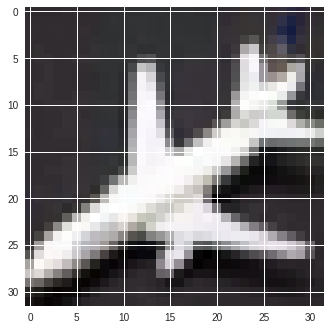

In [0]:
#  |  This is setup, actual work is down
#  |
# \ /
#  V

# Print images with transforms
# Validate data transformations and setup
from matplotlib.pyplot import imshow

img = X_reduced[2]

img = pil_wrap(img)

# Chose level in integer set [0, 1, 2, ... , 10]
img = AutoContrast(img, 9)

img = pil_unwrap(img)

plt.imshow(pil_wrap(img))

**Standardize Training and Output**

In [0]:
#  |  This is setup, actual work is down
#  |
# \ /
#  V

# Standardize training here

batch_size = 250

def plot_history(history, title):
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title(title + ' accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(title + ' loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

def train_model(X, model, aug, epochs, title):

  tic = time.clock()
  history = model_fit(model, aug, (X_validation, y_validation), len(X) // batch_size, epochs)
  toc = time.clock()
  
  accuracy = model_evaluate(model, X_test, y_test)
  
  print('Test accuracy: %.3f (elaspsed time: %ds)' % (accuracy, (toc-tic)))
  acc = model_cond_accuracy(model, X_test, y_test)
  
  for cat, a in zip(categories, acc):
    print(cat, a)
    
  plot_history(history, title)  
    
  return acc
    


**=======================================================================================**
**=======================================================================================**

**Train a base model**

We do this to establish a common starting point in order to avoid increased variation due to random weight initialization.

Test accuracy: 0.413 (elaspsed time: 27s)
airplane 0.526
auto 0.455
bird 0.188
cat 0.125
deer 0.319
dog 0.318
frog 0.714
horse 0.424
ship 0.62
truck 0.443


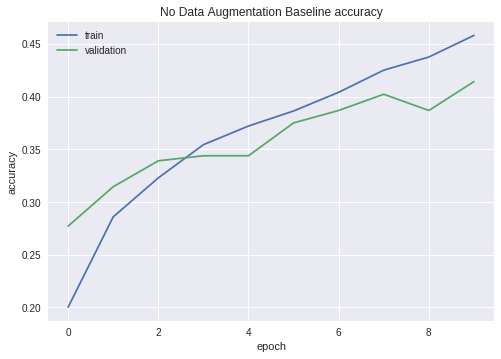

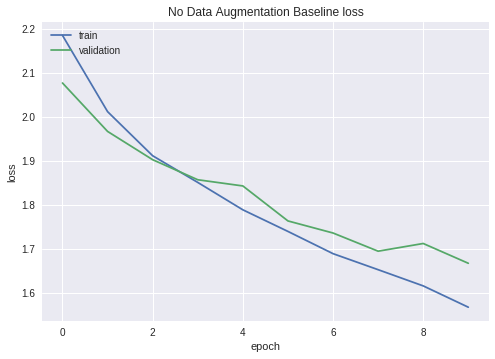

[0.526, 0.455, 0.188, 0.125, 0.319, 0.318, 0.714, 0.424, 0.62, 0.443]

In [0]:
reduced_size = 4000
X_reduced = X[:reduced_size, :, :, :]
y_reduced = y[:reduced_size]
y_reduced = utils.to_categorical(y_reduced)
epochs = 100

# ==============================================================================

ops = [Operation(([Identity] * 10, [0] * 10), 0)]
sub_policy = SubPolicy(*ops)

policy_noop = [sub_policy]
data_noop = autoaugment(policy_noop, X_reduced, y_reduced, batch_size) 

base = create_model(X_reduced, 10)

train_model(X_reduced, base, data_noop, 10, 'No Data Augmentation Baseline')

**Train with no data augmentations: Baseline**

Test accuracy: 0.496 (elaspsed time: 128s)
airplane 0.561
auto 0.646
bird 0.34
cat 0.308
deer 0.657
dog 0.382
frog 0.435
horse 0.53
ship 0.591
truck 0.507


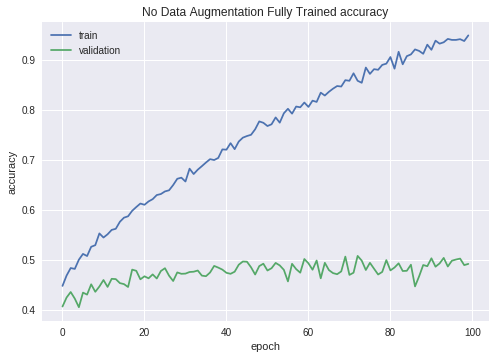

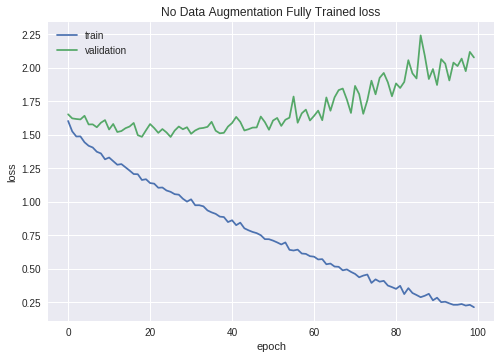

In [0]:
base_final = create_model(X_reduced, 10)
base_final.set_weights(base.get_weights())

accuracy_noop = train_model(X_reduced, base_final, data_noop, epochs, 'No Data Augmentation Fully Trained')

**For every single transform, train a model**

Each model is trained with a simple policy that consists of a single transform applied with probability 1/2 and level 5

=== FlipLR ===
Test accuracy: 0.531 (elaspsed time: 146s)
airplane 0.54
auto 0.654
bird 0.446
cat 0.398
deer 0.684
dog 0.31
frog 0.577
horse 0.49
ship 0.67
truck 0.543


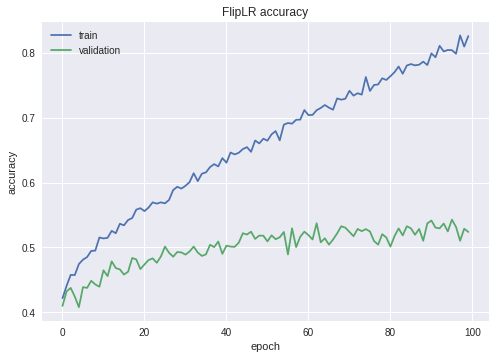

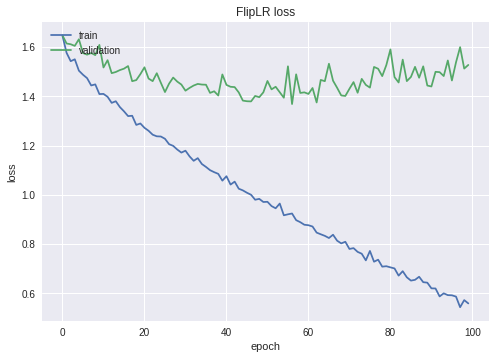

=== FlipUD ===
Test accuracy: 0.466 (elaspsed time: 147s)
airplane 0.535
auto 0.653
bird 0.379
cat 0.249
deer 0.574
dog 0.414
frog 0.582
horse 0.226
ship 0.654
truck 0.397


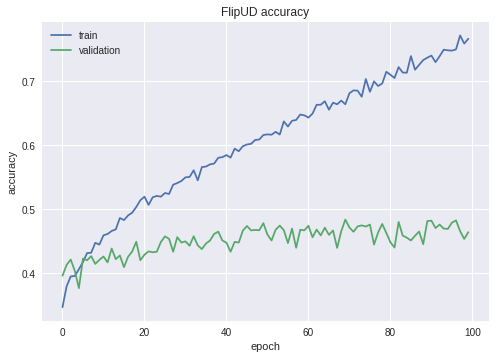

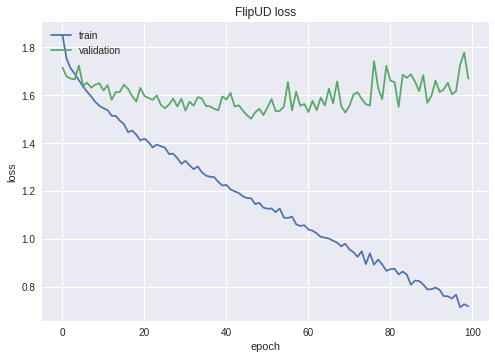

=== AutoContrast ===
Test accuracy: 0.493 (elaspsed time: 151s)
airplane 0.534
auto 0.653
bird 0.31
cat 0.246
deer 0.671
dog 0.437
frog 0.563
horse 0.473
ship 0.574
truck 0.468


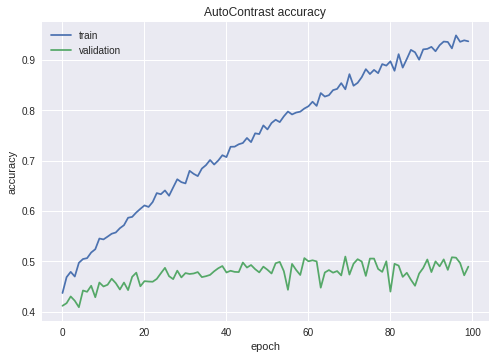

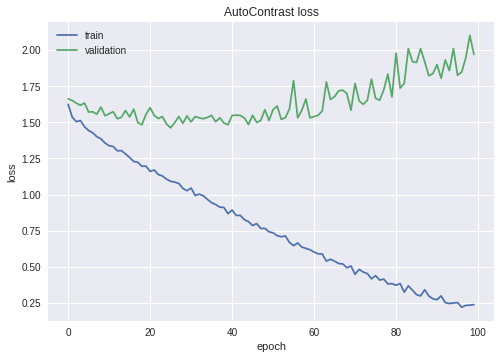

=== Equalize ===
Test accuracy: 0.481 (elaspsed time: 151s)
airplane 0.453
auto 0.605
bird 0.531
cat 0.313
deer 0.51
dog 0.325
frog 0.572
horse 0.444
ship 0.625
truck 0.437


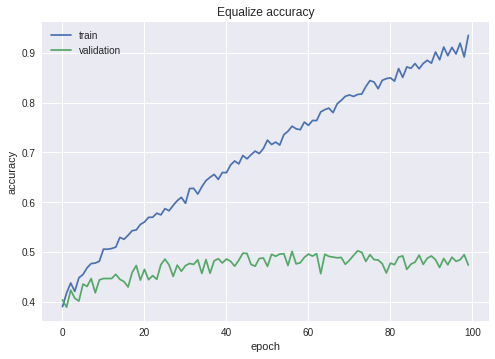

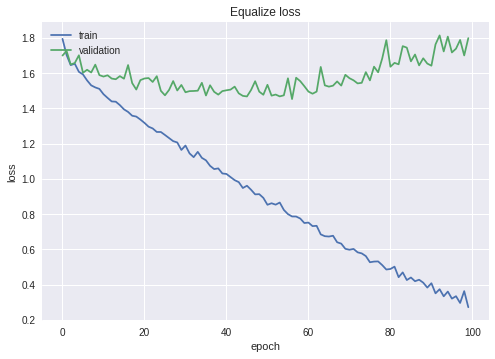

=== Invert ===
Test accuracy: 0.478 (elaspsed time: 144s)
airplane 0.533
auto 0.572
bird 0.412
cat 0.294
deer 0.605
dog 0.302
frog 0.616
horse 0.428
ship 0.583
truck 0.437


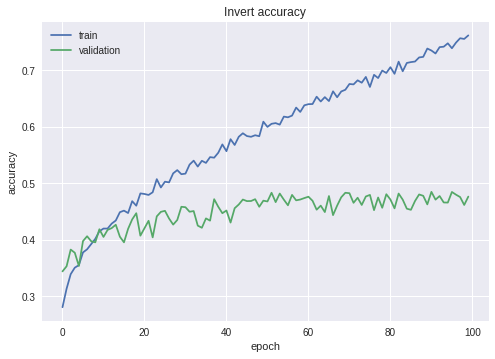

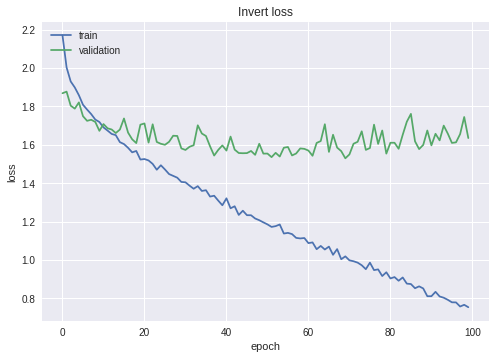

=== Rotate ===
Test accuracy: 0.507 (elaspsed time: 150s)
airplane 0.514
auto 0.583
bird 0.442
cat 0.356
deer 0.643
dog 0.348
frog 0.558
horse 0.501
ship 0.602
truck 0.524


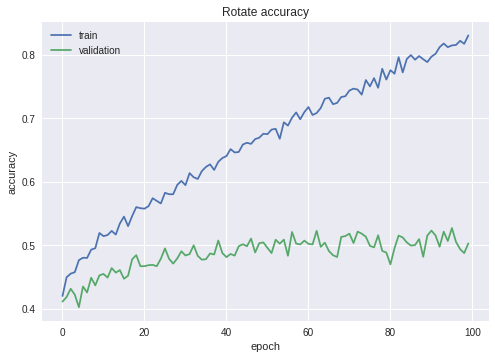

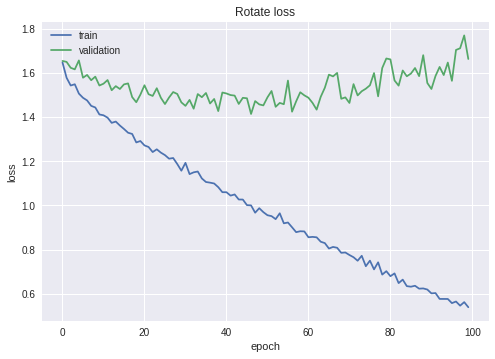

=== Poserize ===
Test accuracy: 0.494 (elaspsed time: 147s)
airplane 0.58
auto 0.702
bird 0.411
cat 0.401
deer 0.499
dog 0.369
frog 0.432
horse 0.586
ship 0.458
truck 0.504


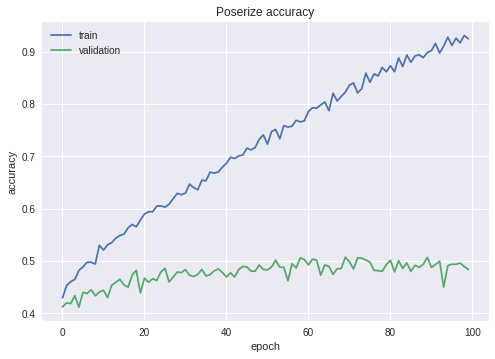

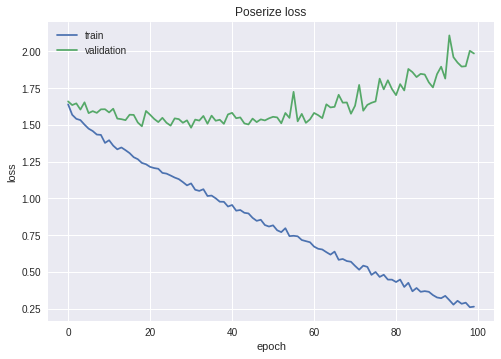

=== Crop ===
Test accuracy: 0.504 (elaspsed time: 150s)
airplane 0.495
auto 0.733
bird 0.256
cat 0.344
deer 0.592
dog 0.377
frog 0.651
horse 0.509
ship 0.588
truck 0.5


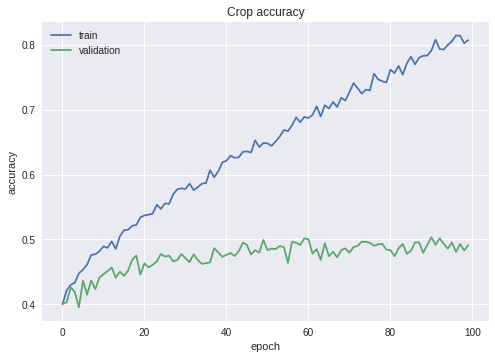

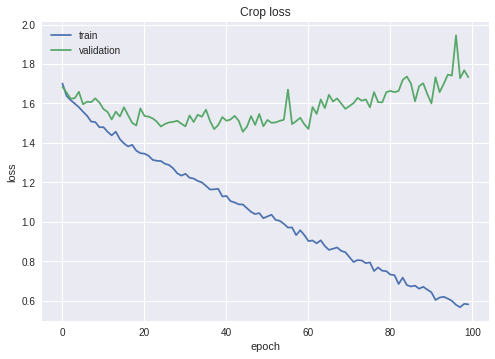

=== Solarize ===
Test accuracy: 0.509 (elaspsed time: 152s)
airplane 0.584
auto 0.687
bird 0.377
cat 0.284
deer 0.674
dog 0.332
frog 0.629
horse 0.463
ship 0.581
truck 0.482


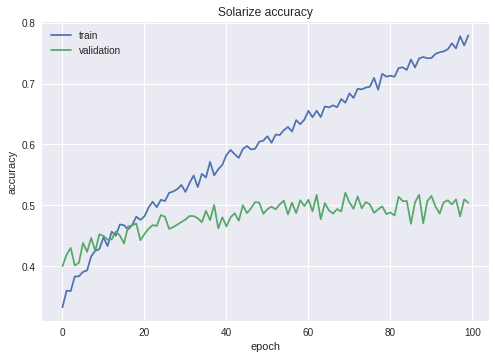

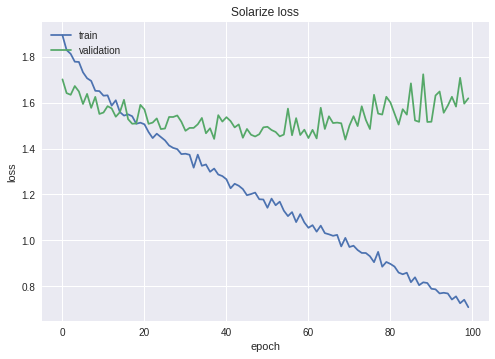

=== Color ===
Test accuracy: 0.497 (elaspsed time: 149s)
airplane 0.559
auto 0.667
bird 0.308
cat 0.371
deer 0.628
dog 0.303
frog 0.567
horse 0.517
ship 0.541
truck 0.506


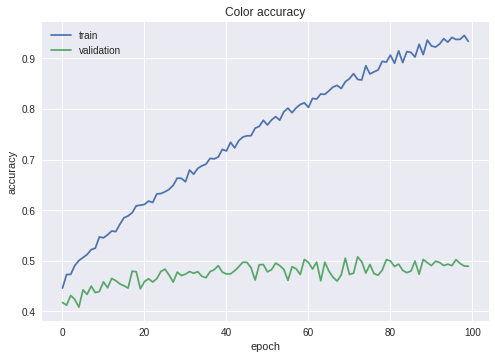

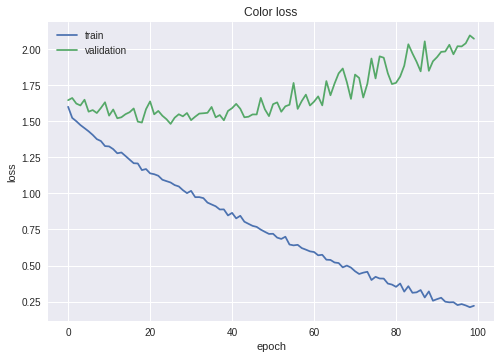

=== Contrast ===
Test accuracy: 0.489 (elaspsed time: 150s)
airplane 0.563
auto 0.624
bird 0.361
cat 0.354
deer 0.63
dog 0.378
frog 0.386
horse 0.506
ship 0.613
truck 0.478


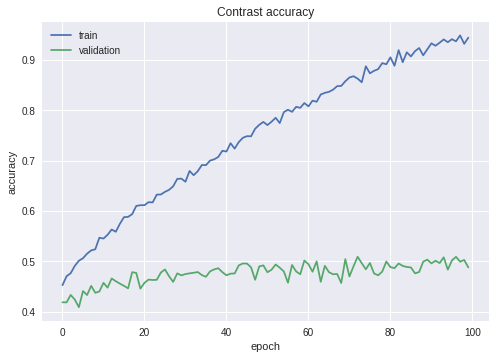

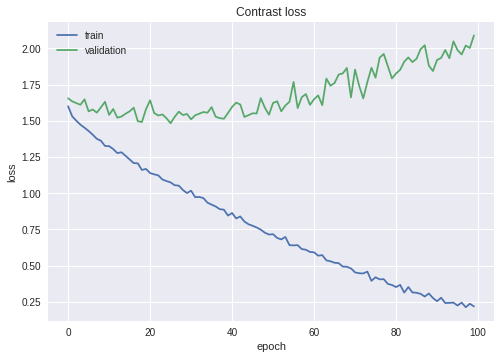

=== Brightness ===
Test accuracy: 0.497 (elaspsed time: 151s)
airplane 0.59
auto 0.637
bird 0.411
cat 0.29
deer 0.554
dog 0.411
frog 0.535
horse 0.467
ship 0.596
truck 0.476


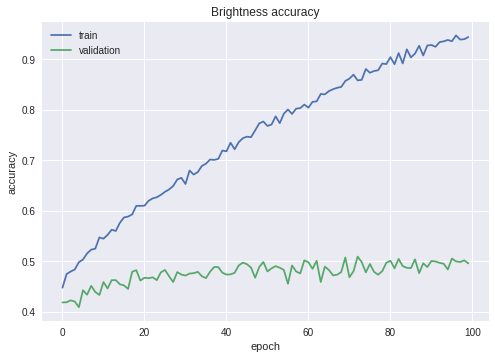

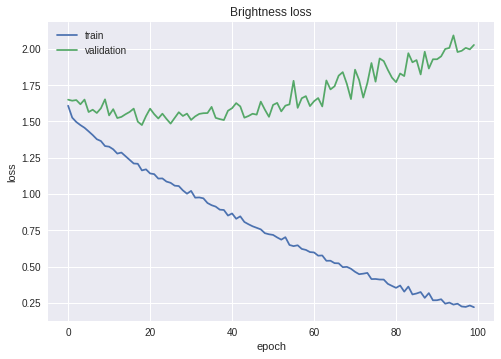

=== Sharpness ===
Test accuracy: 0.501 (elaspsed time: 150s)
airplane 0.57
auto 0.643
bird 0.379
cat 0.285
deer 0.579
dog 0.441
frog 0.517
horse 0.511
ship 0.612
truck 0.473


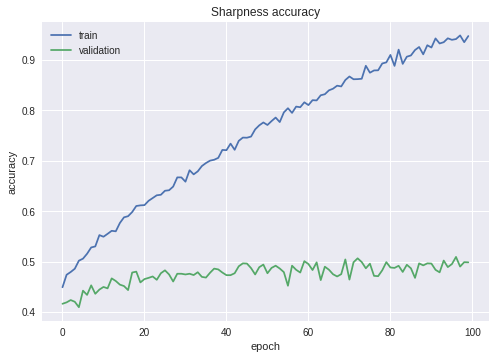

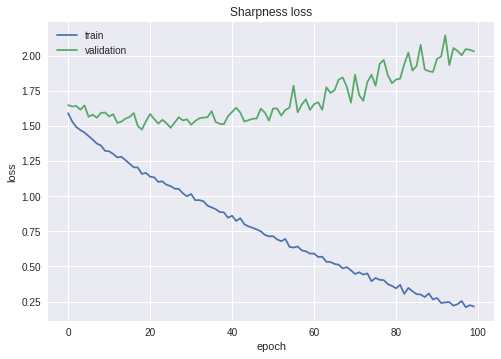

=== ShearX ===
Test accuracy: 0.504 (elaspsed time: 150s)
airplane 0.537
auto 0.674
bird 0.521
cat 0.395
deer 0.533
dog 0.323
frog 0.623
horse 0.416
ship 0.616
truck 0.406


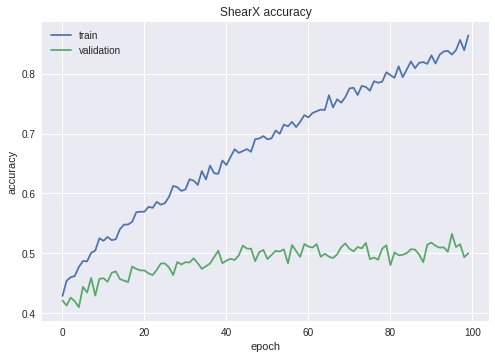

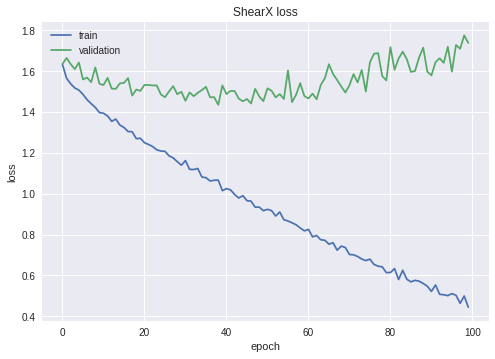

=== ShearY ===
Test accuracy: 0.513 (elaspsed time: 151s)
airplane 0.58
auto 0.686
bird 0.379
cat 0.291
deer 0.668
dog 0.362
frog 0.626
horse 0.48
ship 0.548
truck 0.512


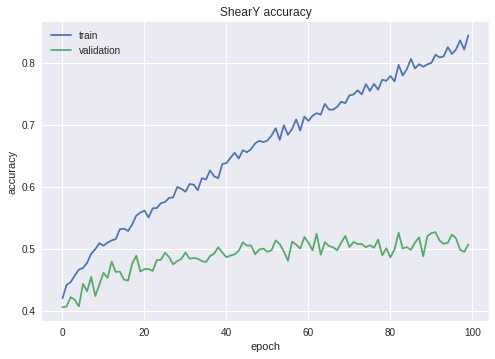

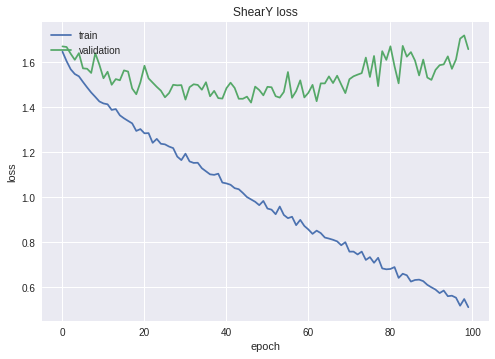

=== TranslateX ===
Test accuracy: 0.525 (elaspsed time: 153s)
airplane 0.539
auto 0.718
bird 0.399
cat 0.362
deer 0.652
dog 0.362
frog 0.581
horse 0.51
ship 0.594
truck 0.537


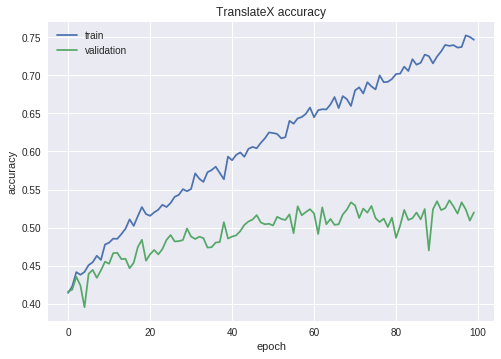

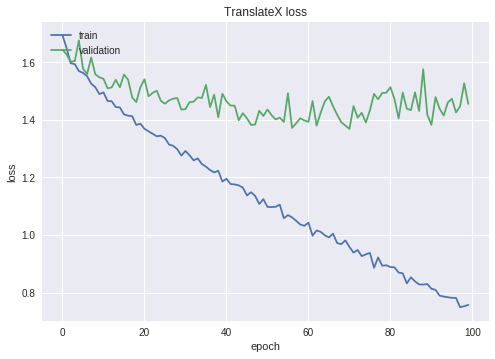

=== TranslateY ===
Test accuracy: 0.527 (elaspsed time: 152s)
airplane 0.658
auto 0.607
bird 0.263
cat 0.376
deer 0.194
dog 0.488
frog 0.812
horse 0.551
ship 0.692
truck 0.627


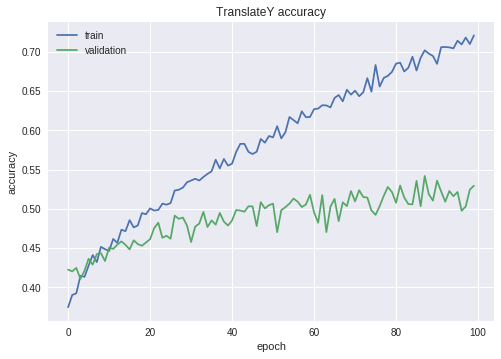

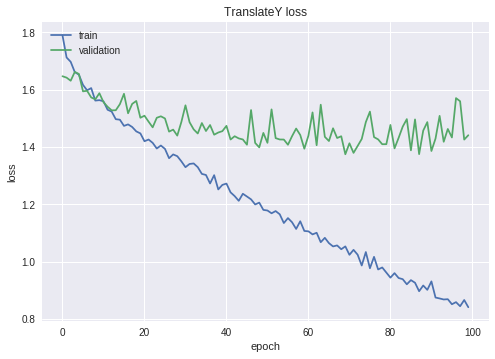

=== Cutout ===
Test accuracy: 0.501 (elaspsed time: 151s)
airplane 0.596
auto 0.601
bird 0.405
cat 0.473
deer 0.304
dog 0.262
frog 0.502
horse 0.696
ship 0.602
truck 0.569


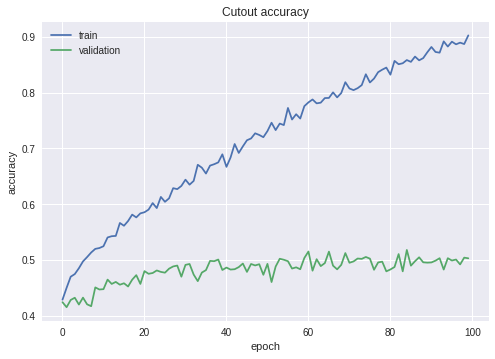

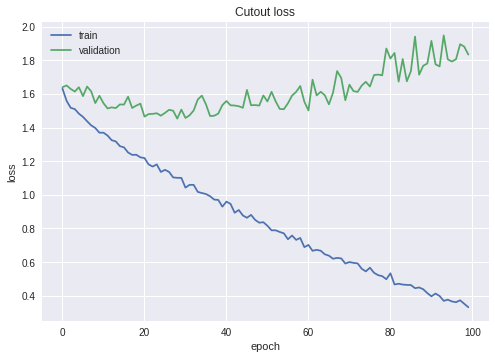

=== Blur ===
Test accuracy: 0.466 (elaspsed time: 153s)
airplane 0.68
auto 0.449
bird 0.244
cat 0.293
deer 0.117
dog 0.368
frog 0.704
horse 0.6
ship 0.66
truck 0.546


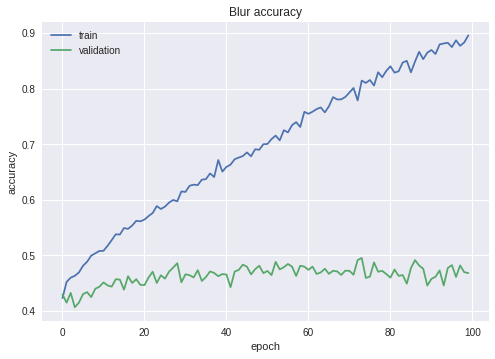

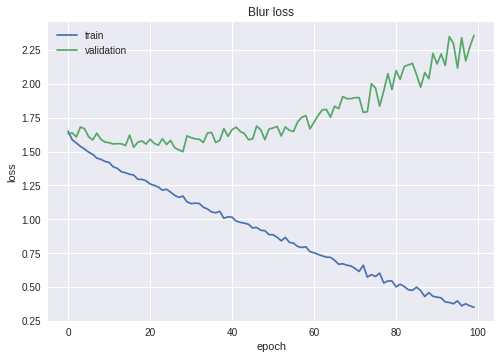

=== Smooth ===
Test accuracy: 0.480 (elaspsed time: 152s)
airplane 0.643
auto 0.424
bird 0.359
cat 0.211
deer 0.145
dog 0.52
frog 0.652
horse 0.611
ship 0.665
truck 0.569


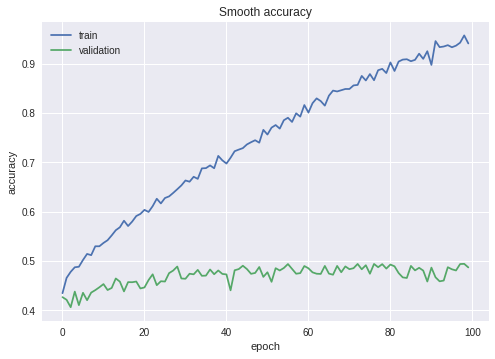

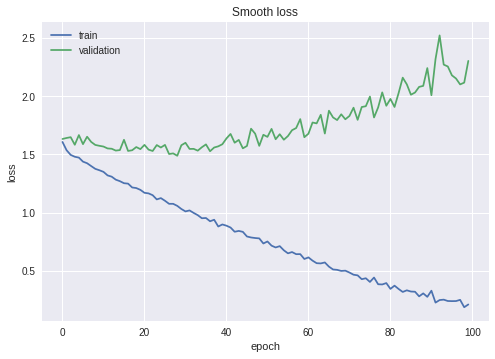

In [0]:
# train for each transform

accuracy_1tform = {}
for name, op in opmap.items():
  print('=== ' + name + ' ===')
  
  #No=op policy
  ops = [Operation(([op] * 10, [5] * 10), 0.5)]
  sub_policy = SubPolicy(*ops)

  policy_i = [sub_policy]
  data_i = autoaugment(policy_i, X_reduced, y_reduced, batch_size) 

  model_i = create_model(X_reduced, 10)
  model_i.set_weights(base.get_weights())
  
  accuracy_1tform[name] = train_model(X_reduced, model_i, data_i, epochs, name)

**Spot check results**

In [0]:
# for each image category, create a tuple of transform name and accuracy delta sorted from best to worst
accuracy_deltas = {}

print('Bese Category Transforms:')
for i, name in enumerate(categories):
  deltas = [(tform_name, acc[i] - accuracy_noop[i]) for tform_name, acc in accuracy_1tform.items()]
  deltas = sorted(deltas, key=lambda x: x[1], reverse = True)
  accuracy_deltas[name] = deltas
  print(name + ':')
  print(' .... %s: %.2f' % (deltas[0][0], 100 * deltas[0][1]))
  print(' .... %s: %.2f' % (deltas[1][0], 100 * deltas[1][1]))
  print(' .... %s: %.2f' % (deltas[3][0], 100 * deltas[3][1]))
  


Bese Category Transforms:
airplane:
 .... Blur: 11.90
 .... TranslateY: 9.70
 .... Cutout: 3.50
auto:
 .... Crop: 8.70
 .... TranslateX: 7.20
 .... Solarize: 4.10
bird:
 .... Equalize: 19.10
 .... ShearX: 18.10
 .... Rotate: 10.20
cat:
 .... Cutout: 16.50
 .... Poserize: 9.30
 .... ShearX: 8.70
deer:
 .... FlipLR: 2.70
 .... Solarize: 1.70
 .... ShearY: 1.10
dog:
 .... Smooth: 13.80
 .... TranslateY: 10.60
 .... AutoContrast: 5.50
frog:
 .... TranslateY: 37.70
 .... Blur: 26.90
 .... Crop: 21.60
horse:
 .... Cutout: 16.60
 .... Smooth: 8.10
 .... Poserize: 5.60
ship:
 .... TranslateY: 10.10
 .... FlipLR: 7.90
 .... Blur: 6.90
truck:
 .... TranslateY: 12.00
 .... Cutout: 6.20
 .... Blur: 3.90


**Explore category targeted policies**

Best approach actually ignores category! 
This policy selects each transform that increased accuracy by one percent and uses it as a subpolicy

FlipLR subpolicy will be applied to
 ... airplane (-2.10%)
 ... auto (0.80%)
 ... bird (10.60%)
 ... cat (9.00%)
 ... deer (2.70%)
 ... dog (-7.20%)
 ... frog (14.20%)
 ... horse (-4.00%)
 ... ship (7.90%)
 ... truck (3.60%)
Rotate subpolicy will be applied to
 ... airplane (-4.70%)
 ... auto (-6.30%)
 ... bird (10.20%)
 ... cat (4.80%)
 ... deer (-1.40%)
 ... dog (-3.40%)
 ... frog (12.30%)
 ... horse (-2.90%)
 ... ship (1.10%)
 ... truck (1.70%)
Solarize subpolicy will be applied to
 ... airplane (2.30%)
 ... auto (4.10%)
 ... bird (3.70%)
 ... cat (-2.40%)
 ... deer (1.70%)
 ... dog (-5.00%)
 ... frog (19.40%)
 ... horse (-6.70%)
 ... ship (-1.00%)
 ... truck (-2.50%)
ShearY subpolicy will be applied to
 ... airplane (1.90%)
 ... auto (4.00%)
 ... bird (3.90%)
 ... cat (-1.70%)
 ... deer (1.10%)
 ... dog (-2.00%)
 ... frog (19.10%)
 ... horse (-5.00%)
 ... ship (-4.30%)
 ... truck (0.50%)
TranslateX subpolicy will be applied to
 ... airplane (-2.20%)
 ... auto (7.20%)
 ... bird (5.9

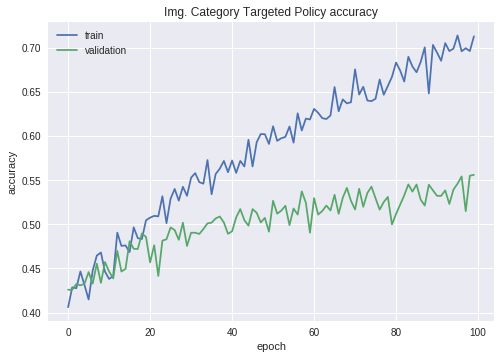

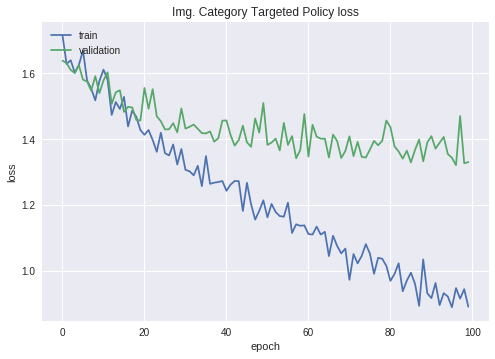

In [0]:
# Use above results to create a new category specific policy

#def mk_new_operation(i, accuracy_deltas):  
#  op = [opmap[dacc[i][0]] if dacc[i][1] > 0.05 else Identity for name, dacc in accuracy_deltas.items()]
#  return Operation((op, [5] * 10), 0.5)
#
#ops1 = [mk_new_operation(0, accuracy_deltas)]
#ops2 = [mk_new_operation(1, accuracy_deltas)]
#
#sub_policy1 = SubPolicy(*ops1)
#sub_policy2 = SubPolicy(*ops2)

#policy_new = [sub_policy1, sub_policy2]



policy_new = list()

for tform_name, accs in accuracy_1tform.items():
  
  if np.average(accs) > np.average(accuracy_noop) + 0.01:
  
    any_good = False
    op = [Identity] * 10
    print(tform_name + ' subpolicy will be applied to')
    for i, acc in enumerate(accs):
      if acc - accuracy_noop[i] > -1.1:
        print(' ... ' + categories[i] + ' (%.2f%s)' % (100 * (acc- accuracy_noop[i]), '%'))
        any_good = True
        op[i] = opmap[tform_name]

    if any_good:
      transform = [Operation((op, [5] * 10), 0.5)]
      sub_policy = SubPolicy(*transform)
      policy_new.append(sub_policy)


data_new = autoaugment(policy_new, X_reduced, y_reduced, batch_size) 

model_new = create_model(X_reduced, 10)
model_new.set_weights(base.get_weights())

accuracy_new = train_model(X_reduced, model_new, data_new, epochs, 'Img. Category Targeted Policy')

In [0]:

acc0 = 100 * np.average(accuracy_noop)
acc1 = 100 * np.average(accuracy_new)

print('%.2f --> %.2f' % (acc0, acc1))
for i, cat in enumerate(categories):
  dacc = accuracy_new[i] - accuracy_noop[i]
  print('%s: %.2f' % (cat, 100 * dacc))

49.57 --> 55.48
airplane: -5.80
auto: 8.70
bird: -3.80
cat: 15.60
deer: -23.60
dog: 10.40
frog: 25.80
horse: 12.10
ship: 16.00
truck: 3.70


**AutoAugment Policy format, but randomly generated**

Test accuracy: 0.531 (elaspsed time: 162s)
airplane 0.62
auto 0.617
bird 0.424
cat 0.364
deer 0.495
dog 0.373
frog 0.695
horse 0.488
ship 0.645
truck 0.591


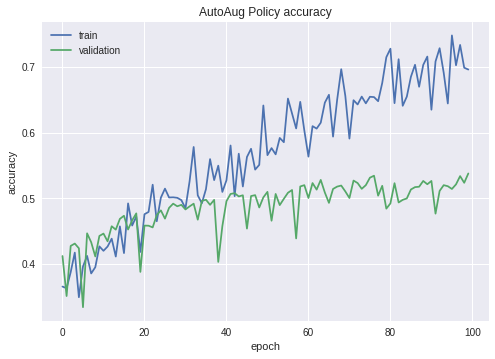

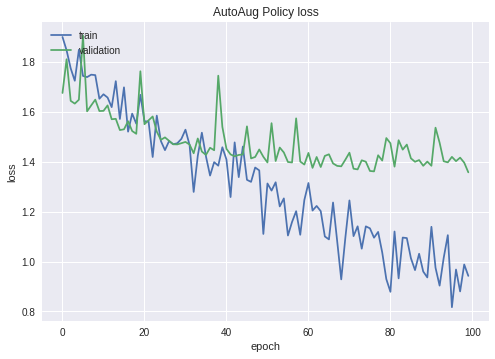

In [0]:
def mk_op2(op1, p1, v1, op2, p2, v2):
  ops = [Operation(([op1] * 10, [v1] * 10), p1), Operation(([op1] * 10, [v1] * 10), p1)]
  return SubPolicy(*ops)

Rand_Policy = [
    mk_op2(Equalize, 0.0, 1, Solarize, 0.1, 2),
    mk_op2(ShearY, 0.6, 5,  Solarize, 0.9, 6),
    mk_op2(Color, 0.2, 7, Color, 0.5, 9),
    mk_op2(Brightness, 0.2, 3, Invert, 0.7, 9),
    mk_op2(AutoContrast, 0.0, 2, AutoContrast, 0.2, 6),
    mk_op2(AutoContrast, 0.9, 8, Solarize, 0.2, 9),
    mk_op2(ShearY, 0.3, 3, AutoContrast, 0.2, 9),
    mk_op2(Cutout, 0.7, 5, TranslateX, 0.3, 3),
    mk_op2(AutoContrast, 0.5, 2, Equalize, 0.3, 5),
    mk_op2(TranslateY, 0.4, 7, TranslateY, 0.8, 4),
    mk_op2(Cutout, 0.3, 5, Cutout, 0.1, 6),
    mk_op2(ShearY, 0.3, 0, Invert, 0.0, 8),
    mk_op2(TranslateY, 0.4, 0, TranslateY, 0.3, 1),
    mk_op2(Color, 0.9, 0, Cutout, 0.5, 6),
    mk_op2(Solarize, 0.3, 3, Cutout, 0.2, 2),
    mk_op2(Invert, 0.8, 9, Solarize, 0.9, 1),
    mk_op2(Invert, 0.7, 0, Invert, 0.3, 0),
    mk_op2(TranslateY, 0.7, 4, Posterize, 0.5, 2),
    mk_op2(Cutout, 0.6, 7, Cutout, 0.6, 5),
    mk_op2(Posterize, 0.7, 3, Solarize, 0.0, 4),
    mk_op2(Equalize, 0.9, 6, Posterize, 0.1, 1),
    mk_op2(AutoContrast, 0.4, 5, ShearX, 0.3, 5),
    mk_op2(ShearY, 0.1, 4, ShearY, 0.0, 4),
    mk_op2(Solarize, 0.9, 0, TranslateY, 0.2, 1),
    mk_op2(Color, 0.4, 5, Color, 0.3, 3)
  ]

data_rand = autoaugment(CIFAR10_Policy, X_reduced, y_reduced, batch_size) 

# create new model and copy base weights over
model_rand = create_model(X_reduced, 10)
model_rand.set_weights(base.get_weights())

accuracy_autoaug_rand = train_model(X_reduced, model_rand, data_rand, epochs, 'AutoAug Policy')

In [0]:
acc0 = 100 * np.average(accuracy_noop)
acc1 = 100 * np.average(accuracy_autoaug_rand)

print('%.2f --> %.2f' % (acc0, acc1))
for i, cat in enumerate(categories):
  dacc = accuracy_autoaug_rand[i] - accuracy_noop[i]
  print('%s: %.2f' % (cat, 100 * dacc))

49.57 --> 53.12
airplane: 5.90
auto: -2.90
bird: 8.40
cat: 5.60
deer: -16.20
dog: -0.90
frog: 26.00
horse: -4.20
ship: 5.40
truck: 8.40


**AutoAugment CIFAR10 Policy**

Test accuracy: 0.533 (elaspsed time: 163s)
airplane 0.624
auto 0.623
bird 0.408
cat 0.388
deer 0.482
dog 0.373
frog 0.68
horse 0.5
ship 0.647
truck 0.61


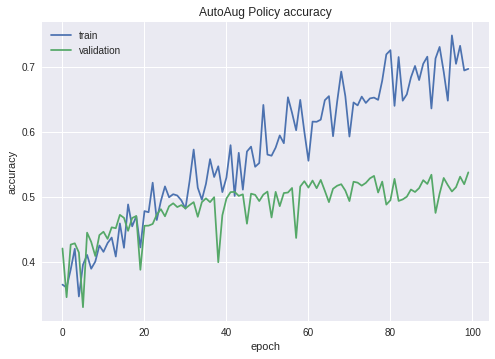

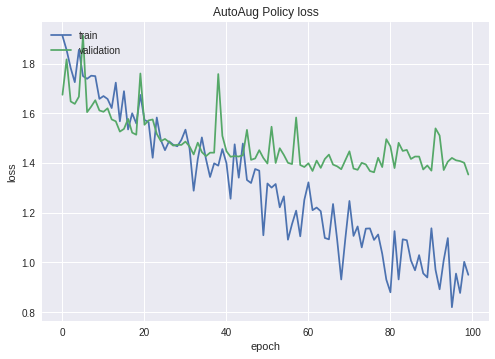

In [0]:
CIFAR10_Policy = [
    #0_0
    mk_op2(Invert, 0.1, 7, Contrast, 0.2, 6),
    mk_op2(Rotate, 0.7, 2, TranslateX, 0.3, 9),
    mk_op2(Sharpness, 0.8, 1, Sharpness, 0.9, 3),
    mk_op2(ShearY, 0.5, 8, TranslateY, 0.7, 9),
    mk_op2(AutoContrast, 0.5, 8, Equalize, 0.9, 2),
    
    #1_0
    mk_op2(ShearY, 0.2, 7, Posterize, 0.3, 7),
    mk_op2(Color, 0.4, 3, Brightness, 0.6, 7),
    mk_op2(Sharpness, 0.3, 9, Brightness, 0.7, 9),
    mk_op2(Equalize, 0.6, 5, Equalize, 0.5, 1),
    mk_op2(Contrast, 0.6, 7, Sharpness, 0.6, 5),
    
    #2_0
    mk_op2(Color, 0.7, 7, TranslateX, 0.5, 8),
    mk_op2(Equalize, 0.3, 7, AutoContrast, 0.4, 8),
    mk_op2(TranslateY, 0.4, 3, Sharpness, 0.2, 6),
    mk_op2(Brightness, 0.9, 6, Color, 0.2, 8),
    mk_op2(Solarize, 0.5, 2, Invert, 0.0, 3),
    
    #3_0
    mk_op2(Equalize,0.2,0, AutoContrast,0.6,0),
    mk_op2(Equalize,0.2,8, Equalize,0.6,4),
    mk_op2(Color,0.9,9, Equalize,0.6,6),
    mk_op2(AutoContrast,0.8,4, Solarize,0.2,8),
    mk_op2(Brightness,0.1,3, Color,0.7,0),
    
    #4_0
    mk_op2(Solarize,0.4,5, AutoContrast,0.9,3),
    mk_op2(TranslateY,0.9,9, TranslateY,0.7,9),
    mk_op2(AutoContrast,0.9,2, Solarize,0.8,3),
    mk_op2(Equalize,0.8,8, Invert,0.1,3),
    mk_op2(TranslateY,0.7,9, AutoContrast,0.9,1)
]

aug_autoaug = autoaugment(CIFAR10_Policy, X_reduced, y_reduced, batch_size) 

# create new model and copy base weights over
model_autoaug = create_model(X_reduced, 10)
model_autoaug.set_weights(base.get_weights())

accuracy_autoaug = train_model(X_reduced, model_autoaug, aug_autoaug, epochs, 'AutoAug Policy')

In [0]:
acc0 = 100 * np.average(accuracy_noop)
acc1 = 100 * np.average(accuracy_autoaug)

print('%.2f --> %.2f' % (acc0, acc1))
for i, cat in enumerate(categories):
  dacc = accuracy_autoaug[i] - accuracy_noop[i]
  print('%s: %.2f' % (cat, 100 * dacc))

49.57 --> 53.35
airplane: 6.30
auto: -2.30
bird: 6.80
cat: 8.00
deer: -17.50
dog: -0.90
frog: 24.50
horse: -3.00
ship: 5.60
truck: 10.30


**AutoAugment Hybrid Random Policy**

Randomly generated from a subset of transforms that increased accuracy by at least one percent

Test accuracy: 0.551 (elaspsed time: 160s)
airplane 0.689
auto 0.631
bird 0.463
cat 0.399
deer 0.331
dog 0.413
frog 0.683
horse 0.511
ship 0.756
truck 0.636


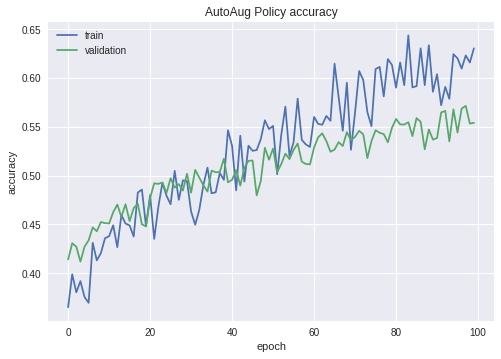

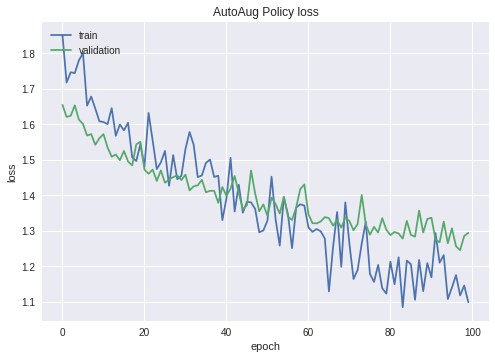

In [0]:
CIFAR10_Hybrid_Policy = [
  mk_op2(TranslateX, 0.1, 3, ShearY, 0.9, 7),
	mk_op2(TranslateY, 0.3, 2, Flip_LR, 0.5, 9),
	mk_op2(Solarize, 0.9, 4, Solarize, 0.5, 7),
	mk_op2(Rotate, 0.2, 7, Rotate, 0.8, 9),
	mk_op2(ShearY, 0.0, 6, ShearY, 0.9, 1),
	mk_op2(TranslateY, 0.0, 2, TranslateY, 0.4, 4),
	mk_op2(Flip_LR, 0.4, 9, TranslateY, 0.9, 3),
	mk_op2(TranslateX, 0.0, 3, TranslateY, 0.5, 4),
	mk_op2(Flip_LR, 0.4, 8, TranslateY, 0.0, 7),
	mk_op2(Flip_LR, 0.8, 8, TranslateX, 0.6, 9),
	mk_op2(ShearY, 0.9, 5, Rotate, 0.0, 4),
	mk_op2(ShearY, 0.5, 9, Solarize, 0.5, 5),
	mk_op2(Solarize, 0.3, 9, TranslateX, 0.3, 3),
	mk_op2(Rotate, 0.9, 5, TranslateY, 0.5, 0),
	mk_op2(TranslateY, 0.1, 8, TranslateY, 0.6, 7),
	mk_op2(Flip_LR, 0.9, 5, Flip_LR, 0.8, 6),
	mk_op2(Flip_LR, 0.6, 2, TranslateX, 0.0, 0),
	mk_op2(Solarize, 0.5, 5, ShearY, 0.4, 2),
	mk_op2(TranslateY, 0.4, 2, TranslateY, 0.8, 0),
	mk_op2(TranslateX, 0.5, 9, TranslateX, 0.9, 3),
	mk_op2(Solarize, 0.1, 6, Flip_LR, 0.8, 7),
	mk_op2(Flip_LR, 0.8, 8, TranslateX, 0.8, 6),
	mk_op2(TranslateY, 0.7, 1, Rotate, 0.6, 6),
	mk_op2(TranslateY, 0.1, 7, ShearY, 0.0, 1),
	mk_op2(Rotate, 0.5, 4, Solarize, 0.6, 2)]

aug_autoaug_hybrid = autoaugment(CIFAR10_Hybrid_Policy, X_reduced, y_reduced, batch_size) 

# create new model and copy base weights over
model_autoaug_hybrid = create_model(X_reduced, 10)
model_autoaug_hybrid.set_weights(base.get_weights())

accuracy_autoaug_hybrid = train_model(X_reduced, model_autoaug_hybrid, aug_autoaug_hybrid, epochs, 'AutoAug Policy')

In [0]:
acc0 = 100 * np.average(accuracy_noop)
acc1 = 100 * np.average(accuracy_autoaug_hybrid)

print('%.2f --> %.2f' % (acc0, acc1))
for i, cat in enumerate(categories):
  dacc = accuracy_autoaug_hybrid[i] - accuracy_noop[i]
  print('%s: %.2f' % (cat, 100 * dacc))

49.57 --> 55.12
airplane: 12.80
auto: -1.50
bird: 12.30
cat: 9.10
deer: -32.60
dog: 3.10
frog: 24.80
horse: -1.90
ship: 16.50
truck: 12.90


**=======================================================================================**
**=======================================================================================**

**Fully Trained with no data augmentation**

Test accuracy: 0.805 (elaspsed time: 2041s)
airplane 0.827
auto 0.905
bird 0.661
cat 0.604
deer 0.793
dog 0.725
frog 0.887
horse 0.876
ship 0.878
truck 0.891


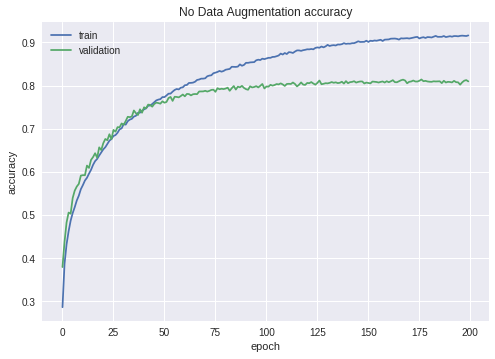

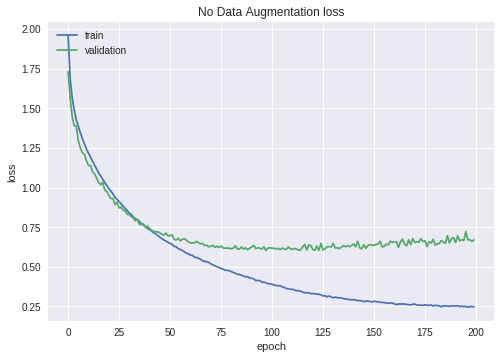

In [9]:
ops = [Operation(([Identity] * 10, [0] * 10), 0)]
sub_policy = SubPolicy(*ops)

policy_full_noop = [sub_policy]
data_full_noop = autoaugment(policy_full_noop, X_train, y_train, batch_size) 

base_full_noop = create_model(X_train, 10, use_dropout = True)

history_full_noop = train_model(X_train, base_full_noop, data_full_noop, 200, 'No Data Augmentation')

**Fully Trained with CIFAR10 AutoAugment Policy**

Test accuracy: 0.819 (elaspsed time: 2343s)
airplane 0.863
auto 0.926
bird 0.723
cat 0.607
deer 0.817
dog 0.704
frog 0.862
horse 0.884
ship 0.92
truck 0.885


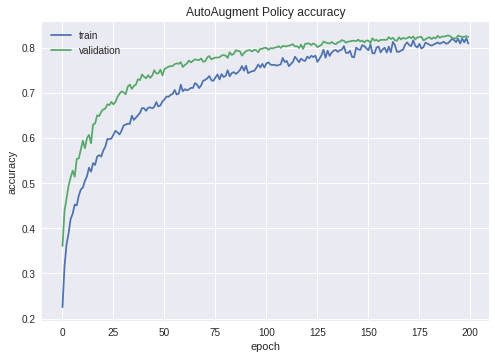

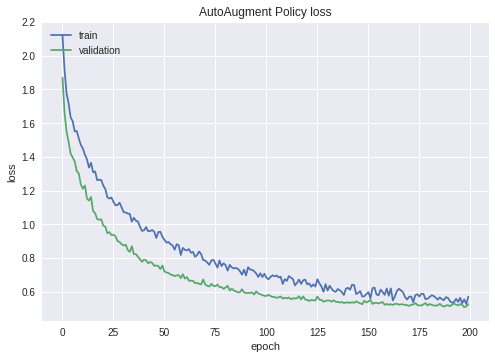

In [11]:
def mk_op2(op1, p1, v1, op2, p2, v2):
  ops = [Operation(([op1] * 10, [v1] * 10), p1), Operation(([op1] * 10, [v1] * 10), p1)]
  return SubPolicy(*ops)

CIFAR10_Policy = [
    #0_0
    mk_op2(Invert, 0.1, 7, Contrast, 0.2, 6),
    mk_op2(Rotate, 0.7, 2, TranslateX, 0.3, 9),
    mk_op2(Sharpness, 0.8, 1, Sharpness, 0.9, 3),
    mk_op2(ShearY, 0.5, 8, TranslateY, 0.7, 9),
    mk_op2(AutoContrast, 0.5, 8, Equalize, 0.9, 2),
    
    #1_0
    mk_op2(ShearY, 0.2, 7, Posterize, 0.3, 7),
    mk_op2(Color, 0.4, 3, Brightness, 0.6, 7),
    mk_op2(Sharpness, 0.3, 9, Brightness, 0.7, 9),
    mk_op2(Equalize, 0.6, 5, Equalize, 0.5, 1),
    mk_op2(Contrast, 0.6, 7, Sharpness, 0.6, 5),
    
    #2_0
    mk_op2(Color, 0.7, 7, TranslateX, 0.5, 8),
    mk_op2(Equalize, 0.3, 7, AutoContrast, 0.4, 8),
    mk_op2(TranslateY, 0.4, 3, Sharpness, 0.2, 6),
    mk_op2(Brightness, 0.9, 6, Color, 0.2, 8),
    mk_op2(Solarize, 0.5, 2, Invert, 0.0, 3),
    
    #3_0
    mk_op2(Equalize,0.2,0, AutoContrast,0.6,0),
    mk_op2(Equalize,0.2,8, Equalize,0.6,4),
    mk_op2(Color,0.9,9, Equalize,0.6,6),
    mk_op2(AutoContrast,0.8,4, Solarize,0.2,8),
    mk_op2(Brightness,0.1,3, Color,0.7,0),
    
    #4_0
    mk_op2(Solarize,0.4,5, AutoContrast,0.9,3),
    mk_op2(TranslateY,0.9,9, TranslateY,0.7,9),
    mk_op2(AutoContrast,0.9,2, Solarize,0.8,3),
    mk_op2(Equalize,0.8,8, Invert,0.1,3),
    mk_op2(TranslateY,0.7,9, AutoContrast,0.9,1)
]

data_full_autoaug = autoaugment(CIFAR10_Policy, X_train, y_train, batch_size) 

# create new model and copy base weights over
model_full_autoaug = create_model(X_train, 10, use_dropout = True)

history_full_autoaug = train_model(X_train, model_full_autoaug, data_full_autoaug, 200, 'AutoAugment Policy')

Test accuracy: 0.823 (elaspsed time: 668s)
airplane 0.859
auto 0.905
bird 0.733
cat 0.672
deer 0.851
dog 0.681
frog 0.882
horse 0.858
ship 0.923
truck 0.87


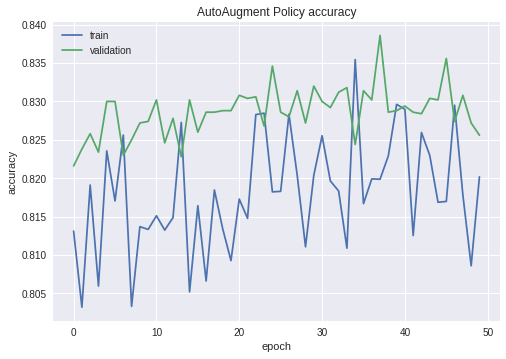

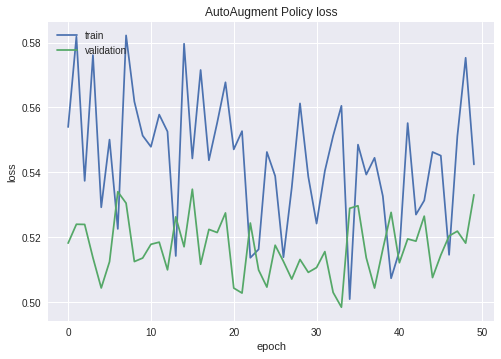

In [16]:
# validation loss hasn't upturned yet... train some more
# after training, validation loss appears to have obtained a minima
history_full_autoaug2 = train_model(X_train, model_full_autoaug, data_full_autoaug, 50, 'AutoAugment Policy')

**Fully train with best policy: "Best Transforms as Subpolicy"**

Test accuracy: 0.831 (elaspsed time: 2466s)
airplane 0.847
auto 0.918
bird 0.724
cat 0.698
deer 0.824
dog 0.717
frog 0.881
horse 0.878
ship 0.911
truck 0.911


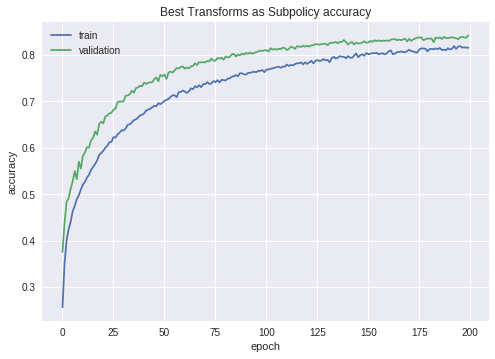

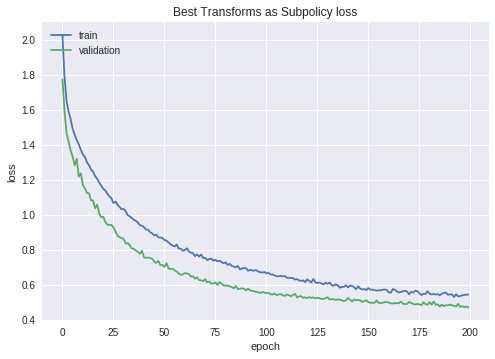

In [14]:
policy_best = list()

for tform_name in ['FlipLR', 'TranslateY', 'TranslateX', 'ShearY', 'Solarize', 'Rotate']:
  
    op = [opmap[tform_name]] * 10
    transform = [Operation((op, [5] * 10), 0.5)]
    sub_policy = SubPolicy(*transform)
    policy_best.append(sub_policy)

data_full_best = autoaugment(policy_best, X_train, y_train, batch_size) 

model_full_best = create_model(X_train, 10, use_dropout = True)

accuracy_full_best = train_model(X_train, model_full_best, data_full_best, 200, 'Best Transforms as Subpolicy')

Test accuracy: 0.835 (elaspsed time: 624s)
airplane 0.88
auto 0.923
bird 0.73
cat 0.674
deer 0.834
dog 0.713
frog 0.922
horse 0.88
ship 0.889
truck 0.906


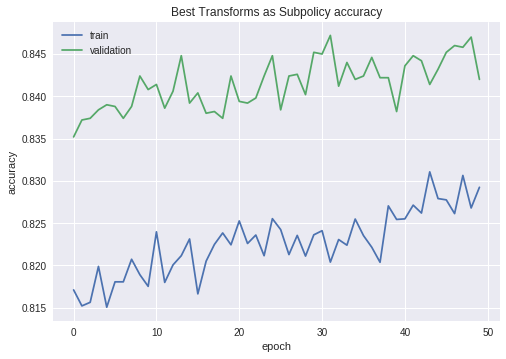

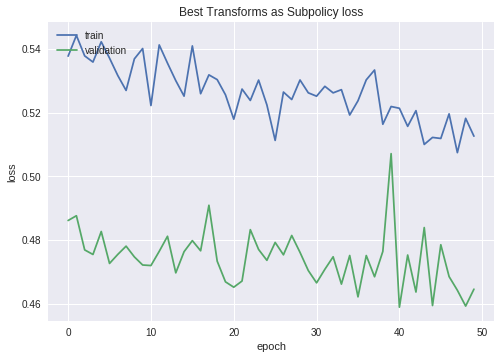

In [15]:
# validation loss hasn't upturned yet... train some more
accuracy_full_best2 = train_model(X_train, model_full_best, data_full_best, 50, 'Best Transforms as Subpolicy')

Test accuracy: 0.841 (elaspsed time: 659s)
airplane 0.86
auto 0.933
bird 0.734
cat 0.691
deer 0.833
dog 0.759
frog 0.91
horse 0.866
ship 0.913
truck 0.915


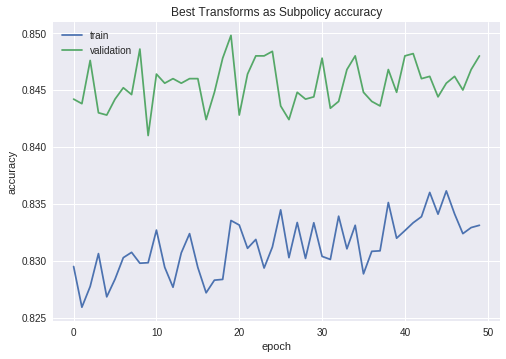

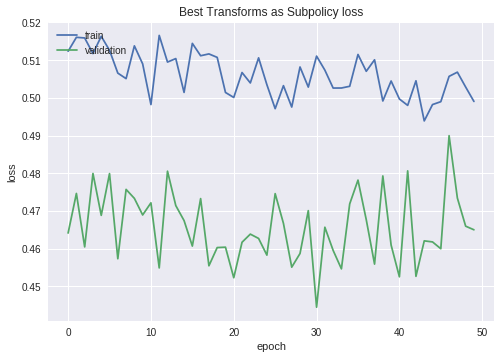

In [17]:
# validation loss hasn't upturned yet... train some more
accuracy_full_best2 = train_model(X_train, model_full_best, data_full_best, 50, 'Best Transforms as Subpolicy')